In [136]:
import numpy as np
import pandas as pd
import ast 
import matplotlib.pyplot as plt
import seaborn as sns

In [137]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [138]:
train = pd.read_csv('train_set.csv')
train = train.drop(columns=["filename"])
train.sample(5)

,head_movement,feature_lengths,flicker,blink,lip_movement_variance,ssim,psnr,pulse,fake
17,"[-0.6795510868726463, -0.4445615697852283, -1....","[45, 5, 5, 50, 50, 45, 45]","[-0.8055748343467712, 1.4023289680480957, -1.0...","[9, 7, 2, 10, 7]","[0.873015873015873, 1.4814814814814816, 0.6371...","[0.858044626334909, -1.3168229974773227, 1.090...","[0.5596153027299786, -1.0972061502981307, 1.85...","[np.float64(49.2628), np.float64(49.2628), np....",1
22,"[-1.7242642280110878, -1.9984680062170292, -0....","[45, 5, 5, 50, 50, 45, 45]","[-0.7165854573249817, 0.49686551094055176, -0....","[2, 0, 8, 0, 4]","[0.8628669719059121, 0.9722222222222222, 0.745...","[0.6151806558863544, -0.16963184436401627, 0.3...","[1.0625584238221115, -0.8696723851316323, 0.05...","[np.float64(97.226), np.float64(97.226), np.fl...",1
29,"[-0.7645984022234743, -0.7152423519383067, -1....","[45, 5, 5, 50, 50, 45, 45]","[-0.6896160244941711, 0.1398618072271347, -0.8...","[1, 0, 0, 4, 6]","[0.8395662798164727, 0.5461546136793604, 1.077...","[0.785340900508427, -0.44912828906134966, 0.88...","[0.7017880210377696, -0.7935833221677464, 0.98...","[np.float64(110.7616), np.float64(110.7924), n...",0
1,"[-0.2860707930511538, -0.2860707930511538, -1....","[45, 5, 5, 50, 50, 45, 45]","[-0.7352153658866882, -0.06433255225419998, -0...","[2, 0, 0, 0, 4]","[0.8395662798164726, 1.0619766763577223, 0.828...","[0.9224829297966465, -0.5719733636365226, 1.09...","[0.6902879105596079, -0.7858917294454759, 1.36...","[np.float64(98.8368), np.float64(99.5108), np....",0
3,"[-0.8148675349460605, -0.8148675349460605, -0....","[45, 5, 5, 50, 50, 45, 45]","[-1.0070769786834717, 0.8262362480163574, -1.1...","[0, 3, 4, 2, 0]","[1.088662107903635, 1.311859599864291, 0.85470...","[1.020598634047629, -0.9507252149224188, 1.117...","[1.3230831674506274, -0.9179443804713251, 1.78...","[np.float64(72.908), np.float64(72.9028), np.f...",0


In [139]:
test = pd.read_csv('test_set.csv')
test = test.drop(columns=["filename"])
test.sample(5)

,head_movement,feature_lengths,flicker,blink,lip_movement_variance,ssim,psnr,pulse,fake
29,"[-0.3606131672859192, -0.3645090162754059, -0....","[45.0, 5.0, 5.0, 50.0, 50.0, 45.0, 45.0]","[-0.8512588143348694, -0.32476305961608887, -0...","[7.0, 1.0, 6.0, 8.0, 9.0]","[0.9647145867347717, 0.42165422439575195, 0.58...","[1.1330674886703491, -0.1005677804350853, 1.05...","[1.5932230949401855, -0.13704264163970947, 1.2...","[-1.5011776685714722, -1.3710341453552246, 0.6...",0
36,"[0.6432075500488281, 1.2715579271316528, -1.26...","[45.0, 5.0, 5.0, 50.0, 50.0, 45.0, 45.0]","[-0.9648782014846802, 1.4790561199188232, -1.0...","[3.0, 6.0, 8.0, 6.0, 5.0]","[0.7017543911933899, 0.7626738548278809, 0.858...","[1.0447494983673096, -1.5315824747085571, 1.11...","[1.1586577892303467, -1.0931217670440674, 1.45...","[-1.7755181789398193, -1.628624439239502, -0.1...",0
34,"[0.3661330044269562, 1.4338096380233765, 0.354...","[45.0, 5.0, 5.0, 50.0, 50.0, 45.0, 45.0]","[-0.975887656211853, -0.17938509583473206, -0....","[9.0, 2.0, 4.0, 7.0, 8.0]","[1.1417380571365356, 0.9363344311714172, 1.180...","[0.9210083484649658, 0.243233785033226, 0.8381...","[1.7459708452224731, 0.10887397825717926, 0.89...","[0.6569674611091614, 0.2321694791316986, -0.73...",0
3,"[-0.9880855083465576, -0.9880855083465576, -0....","[45.0, 5.0, 5.0, 50.0, 50.0, 45.0, 45.0]","[-1.0797076225280762, -0.9694868922233582, -1....","[0.0, 0.0, 0.0, 4.0, 0.0]","[0.8385254740715027, 0.8864844441413879, 0.949...","[1.045573353767395, 0.9237593412399292, 1.0169...","[1.9297069311141968, 0.8410022258758545, 1.025...","[-1.204067587852478, -1.3140281438827515, -0.9...",1
24,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[45.0, 5.0, 5.0, 50.0, 50.0, 45.0, 45.0]","[-0.4494619369506836, 2.3388519287109375, -0.7...","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.4942168891429901, -1.6031447649002075, 0.86...","[-0.5600479245185852, -1.3242520093917847, 0.7...","[1.9781123399734497, 1.9902575016021729, -0.70...",0


In [140]:
# Option 1: Concatenate all features (flatten nested lists)

def safe_eval_np_float64(x):
    if isinstance(x, str):
        return eval(x, {"np": np})
    return x

for col in train.columns:
    if col != "fake":
        train[col] = train[col].apply(safe_eval_np_float64)
    
for col in test.columns:
    if col != "fake":
        test[col] = test[col].apply(ast.literal_eval)

In [141]:
# Flatten each row of lists into a single feature vector
X_train = np.array([np.concatenate(row.values) for _, row in train.drop(columns=["fake"]).iterrows()])
y_train = train["fake"].values

X_test = np.array([np.concatenate(row.values) for _, row in test.drop(columns=["fake"]).iterrows()])
y_test = test["fake"].values

In [142]:
# #option 2: summarize each list with aggregate features (mean, std, etc.)
# for col in df.columns:
#     if col != "fake":
#         df[col] = df[col].apply(ast.literal_eval)

# agg_df = df.copy()
# for col in df.columns:
#     if col != "fake":
#         agg_df[f"{col}_mean"] = df[col].apply(np.mean)
#         agg_df[f"{col}_std"] = df[col].apply(np.std)
#         agg_df[f"{col}_max"] = df[col].apply(np.max)
#         agg_df[f"{col}_min"] = df[col].apply(np.min)

# # drop the original list-based columns
# agg_df = agg_df.drop(columns=[col for col in df.columns if col != "fake"])

# # final X and y
# X = agg_df.drop(columns=["fake"]).values
# y = agg_df["fake"].values

In [143]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.7, random_state=27)

In [144]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Function to run model

In [145]:
def evaluate_model(model, model_name):
    print(f"Training {model_name}...")
    
    # Fit model
    model.fit(X_train, y_train)
    
    # Predict on test data
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC (probabilities for positive class)
    
    target_names = ["Authentic", "Deepfake"]
    
    # Calculate accuracy, AUC, and confusion matrix
    acc = metrics.accuracy_score(y_test, y_pred)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = round(metrics.auc(fpr, tpr), 2)
    cm = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=target_names)
    
    # Print the classification report for the model
    print(f"Classification Report for {model_name}:\n{class_report}\n")

    # Plot confusion matrix for the model
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(cm, annot=True, cmap='Blues_r', fmt='g', xticklabels=target_names, yticklabels=target_names, ax=ax)
    ax.set_xlabel("Predicted Values")
    ax.set_ylabel("Actual Values")
    ax.set_title(f"Confusion Matrix for {model_name}")
    plt.show()

    return acc, auc, cm

Logistic Regression

Training Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

   Authentic       0.69      0.30      0.42        30
    Deepfake       0.43      0.80      0.56        20

    accuracy                           0.50        50
   macro avg       0.56      0.55      0.49        50
weighted avg       0.59      0.50      0.48        50




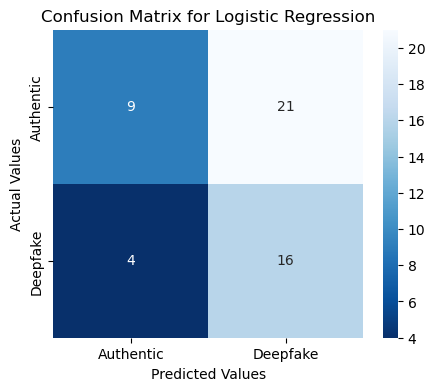

In [146]:
log_reg = LogisticRegression(solver='liblinear')
log_reg_acc, log_reg_auc, log_reg_cm = evaluate_model(log_reg, "Logistic Regression")

Decision Tree

Training Decision Tree...
Classification Report for Decision Tree:
              precision    recall  f1-score   support

   Authentic       0.64      0.47      0.54        30
    Deepfake       0.43      0.60      0.50        20

    accuracy                           0.52        50
   macro avg       0.53      0.53      0.52        50
weighted avg       0.55      0.52      0.52        50




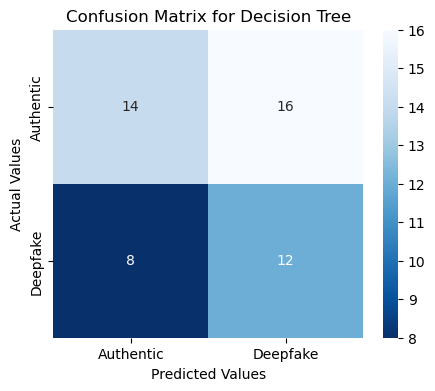

In [147]:
dt = DecisionTreeClassifier()
dt_acc, dt_auc, dt_cm = evaluate_model(dt, "Decision Tree")

Naive Bayes


Training Naive Bayes...
Classification Report for Naive Bayes:
              precision    recall  f1-score   support

   Authentic       0.70      0.47      0.56        30
    Deepfake       0.47      0.70      0.56        20

    accuracy                           0.56        50
   macro avg       0.58      0.58      0.56        50
weighted avg       0.61      0.56      0.56        50




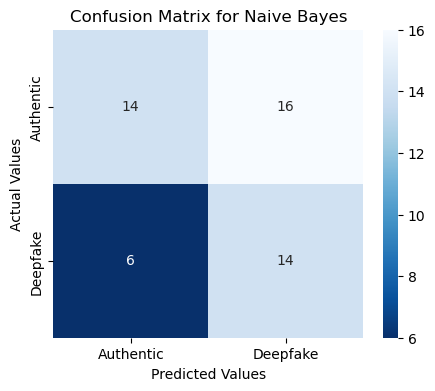

In [148]:
nb = GaussianNB()
nb_acc, nb_auc, nb_cm = evaluate_model(nb, "Naive Bayes")

K Nearest Neighbours

Training KNN...
Classification Report for KNN:
              precision    recall  f1-score   support

   Authentic       0.00      0.00      0.00        30
    Deepfake       0.40      1.00      0.57        20

    accuracy                           0.40        50
   macro avg       0.20      0.50      0.29        50
weighted avg       0.16      0.40      0.23        50




c:\Users\user\anaconda3\envs\is217_env\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\envs\is217_env\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\envs\is217_env\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


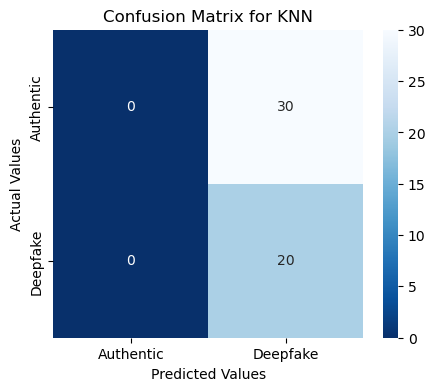

In [149]:
knn = KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree', n_jobs=-1)
knn_acc, knn_auc, knn_cm = evaluate_model(knn, "KNN")

SVM

Training SVM...
Classification Report for SVM:
              precision    recall  f1-score   support

   Authentic       0.00      0.00      0.00        30
    Deepfake       0.40      1.00      0.57        20

    accuracy                           0.40        50
   macro avg       0.20      0.50      0.29        50
weighted avg       0.16      0.40      0.23        50




c:\Users\user\anaconda3\envs\is217_env\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\envs\is217_env\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\envs\is217_env\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


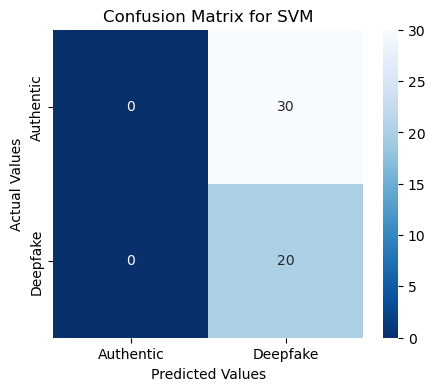

In [150]:
svm = SVC(probability=True)
svm_acc, svm_auc, svm_cm = evaluate_model(svm, "SVM")

Random Forrest

Training Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

   Authentic       0.62      0.33      0.43        30
    Deepfake       0.41      0.70      0.52        20

    accuracy                           0.48        50
   macro avg       0.52      0.52      0.48        50
weighted avg       0.54      0.48      0.47        50




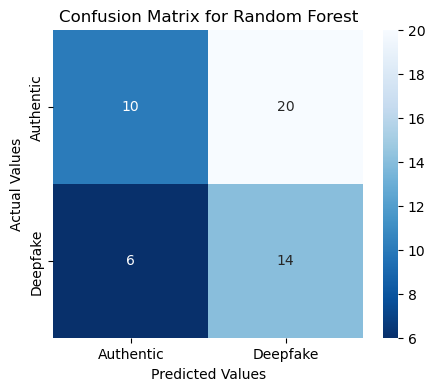

In [151]:
rf = RandomForestClassifier()
rf_acc, rf_auc, rf_cm = evaluate_model(rf, "Random Forest")

AdaBoost

Training AdaBoost...
Classification Report for AdaBoost:
              precision    recall  f1-score   support

   Authentic       0.60      0.50      0.55        30
    Deepfake       0.40      0.50      0.44        20

    accuracy                           0.50        50
   macro avg       0.50      0.50      0.49        50
weighted avg       0.52      0.50      0.51        50




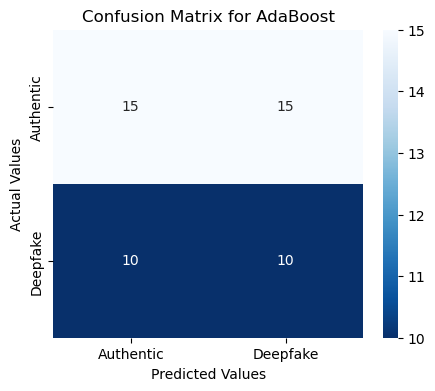

In [152]:
from sklearn.ensemble import AdaBoostClassifier

ada_model= AdaBoostClassifier(n_estimators=100, random_state=27)
ada_acc, ada_auc, ada_cm = evaluate_model(ada_model, "AdaBoost")

XGBoost

In [153]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


Training XGBoost...
Classification Report for XGBoost:
              precision    recall  f1-score   support

   Authentic       0.69      0.60      0.64        30
    Deepfake       0.50      0.60      0.55        20

    accuracy                           0.60        50
   macro avg       0.60      0.60      0.59        50
weighted avg       0.62      0.60      0.60        50




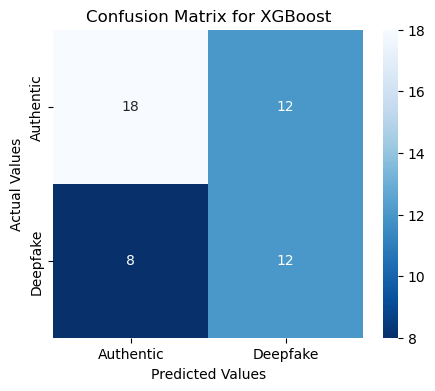

In [154]:
from xgboost import XGBClassifier
xgb =  XGBClassifier(n_estimators=100, random_state=27)
xgb_acc, xgb_auc, xgb_cm = evaluate_model(xgb, "XGBoost")

CatBoost

In [155]:
! pip install catboost

Training CatBoost...
Classification Report for CatBoost:
              precision    recall  f1-score   support

   Authentic       0.68      0.50      0.58        30
    Deepfake       0.46      0.65      0.54        20

    accuracy                           0.56        50
   macro avg       0.57      0.57      0.56        50
weighted avg       0.59      0.56      0.56        50




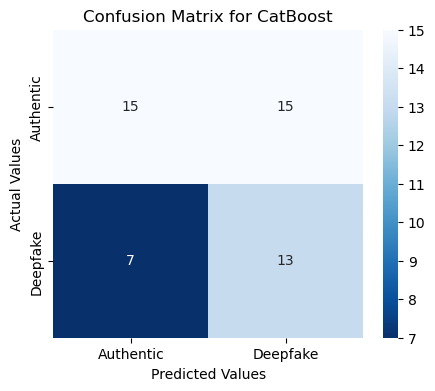

In [156]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(verbose=0) 
cat_acc, cat_auc, cat_cm = evaluate_model(cat_model, "CatBoost")

Summary of Evaluation


In [157]:
print("\nSummary of Results:")
models = ["Logistic Regression", "SVM", "KNN", "Decision Tree", "Random Forest", "Naive Bayes", "AdaBoost", "XGBoost", "CatBoost"]
accuracies = [log_reg_acc, svm_acc, knn_acc, dt_acc, rf_acc, nb_acc, ada_acc, xgb_acc, cat_acc]
auc_scores = [log_reg_auc, svm_auc, knn_auc, dt_auc, rf_auc, nb_auc, ada_auc, xgb_auc, cat_auc]
confusion_matrices = [log_reg_cm, svm_cm, knn_cm, dt_cm, rf_cm, nb_cm, ada_cm, xgb_cm, cat_cm]

rounded_accuracies = [round(acc, 2) for acc in accuracies]

results = {
    "Model": models,
    "Accuracy": rounded_accuracies,
    "AUC": auc_scores,
    "Confusion Matrix": confusion_matrices
}

# Create the DataFrame
results_df = pd.DataFrame(results)

# Print the DataFrame
print(results_df)


Summary of Results:
                 Model  Accuracy   AUC      Confusion Matrix
0  Logistic Regression      0.50  0.56    [[9, 21], [4, 16]]
1                  SVM      0.40  0.42    [[0, 30], [0, 20]]
2                  KNN      0.40  0.50    [[0, 30], [0, 20]]
3        Decision Tree      0.52  0.53   [[14, 16], [8, 12]]
4        Random Forest      0.48  0.58   [[10, 20], [6, 14]]
5          Naive Bayes      0.56  0.55   [[14, 16], [6, 14]]
6             AdaBoost      0.50  0.48  [[15, 15], [10, 10]]
7              XGBoost      0.60  0.59   [[18, 12], [8, 12]]
8             CatBoost      0.56  0.57   [[15, 15], [7, 13]]


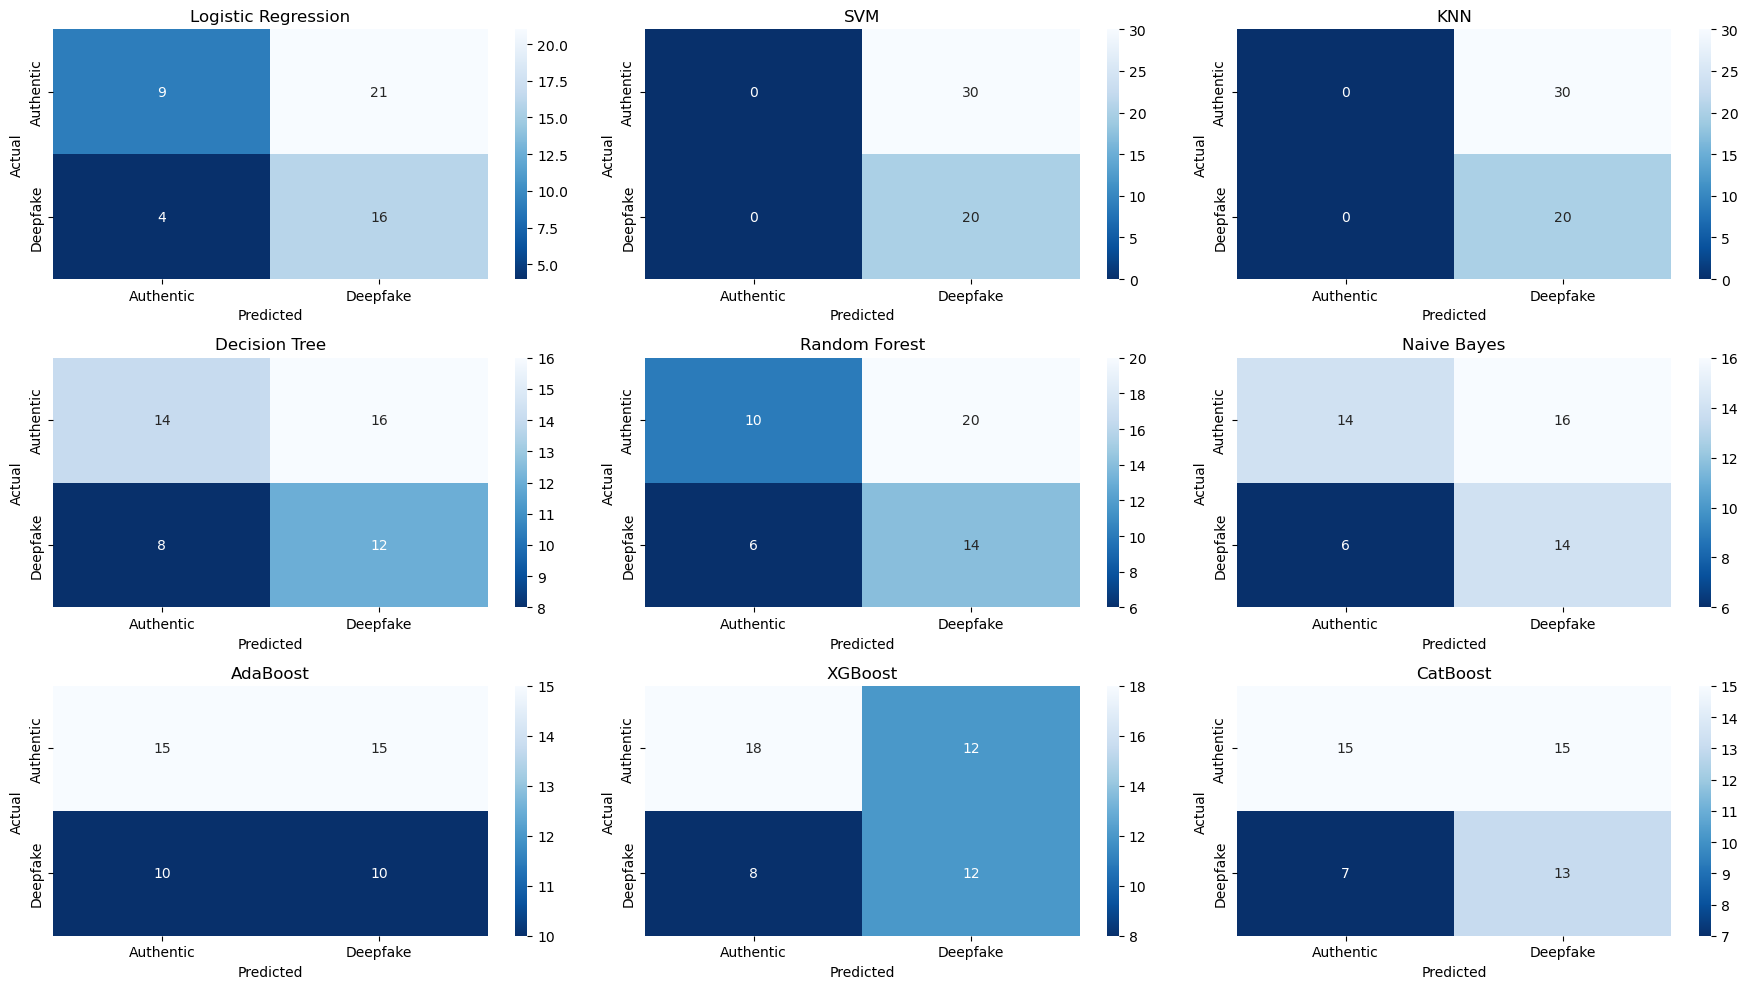

In [ ]:
# List of models and their confusion matrices
models = ["Logistic Regression", "SVM", "KNN", "Decision Tree", "Random Forest", "Naive Bayes", "AdaBoost", "XGBoost", "CatBoost"]
confusion_matrices = [log_reg_cm, svm_cm, knn_cm, dt_cm, rf_cm, nb_cm, ada_cm, xgb_cm, cat_cm]

# Set up the plot
plt.figure(figsize=(18, 10))

target_names = ["Authentic", "Deepfake"]
    
for i, (model, cm) in enumerate(zip(models, confusion_matrices)):
    plt.subplot(3, 3, i + 1)  
    sns.heatmap(cm, annot=True, cmap='Blues_r', fmt='g', xticklabels=target_names, yticklabels=target_names)
    plt.title(model)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()